#### Libraries

In [1]:
import copy, time
import random
import pdb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [2]:
from IPython import display
matplotlib.rcParams['figure.figsize'] = [26,8]

#### Generic Utils 

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def check(val, msg):
    '''Checks whether val is nan or inf and prints msg if True'''
    if (val * 0 != 0): print(msg); pdb.set_trace()
        
def to_numpy(t):
    '''PyTorch tensor to numpy array'''
    return t.detach().to('cpu').numpy()

#### Model

In [4]:
# PyTorch
device = torch.device('cpu')

# Data
X = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1).to(device)
Y = - X*X*X*X + 3*X*X + 1

# Plotting range
x_range = torch.arange(-5,5,0.05).reshape(-1,1)

# BBVI hyperparameters
fn_samples = 1000 # function samples after convergence
learning_rate = 1e-4 # learning rate

In [5]:
class SingleLayerNet(nn.Module):
    def __init__(self, h):
        super(SingleLayerNet, self).__init__()
        self.h = h

        # First 31 are means, last 31 are log_stds
        self.lambdas = nn.Parameter(torch.zeros(62))
        self.lambdas.data[:31].fill_(0.0)
        self.lambdas.data[31:].fill_(0.5)
        
    def forward(self, x, sample):
        
        # Unroll sample weights
        w1 = sample[  :10].reshape(1,10)
        b1 = sample[10:20].reshape(1,10)
        w2 = sample[20:30].reshape(10,1)
        b2 = sample[30:31].reshape( 1,1)
        
        # Forward pass
        x = (x-w1) / b1 # x = x @ w1 + b1 # 
        x = torch.exp(-x*x) # torch.exp(-(x-w1)*(x-w1) / (b1*b1)) 
        x = x @ w2 + b2
        return x 

In [6]:
def BBVI(x, y, model, optimizer, num_samples=1000, epochs=int(20e3), seed=None):
    '''Performs black-box variational inference'''
    torch.manual_seed(seed if seed else random.randint(0,1000))
        
    # Track ELBO statistics
    elbo_meter = AverageMeter()
    elbo_hist = []
    
    # Prior
    p_dist = Normal(torch.zeros(31), 3.16 * torch.ones(31)) 
    
    for ix_e in range(epochs):
        gradients = torch.zeros(62)
        for ix_s in range(num_samples):
            
            # Distributions
            q_dist = Normal(model.lambdas[:31], F.softplus(model.lambdas[31:])) # torch.exp

            # Sample weights
            sample = q_dist.sample()
                        
            # Likelihood
            y_hat = model.forward(x, sample)
            log_l = Normal(y_hat.squeeze(), 0.1 * torch.ones(6)).log_prob(y.squeeze()).sum()
            
            # Regularization
            log_p = p_dist.log_prob(sample).sum()
            log_q = q_dist.log_prob(sample).sum()
            
            # ELBO = log likelihood + log p - log q
            elbo = (log_l + log_p - log_q).squeeze()
            
            # Store gradients
            model.zero_grad()
            optimizer.zero_grad()
            log_q.backward()
            gradients += model.lambdas.grad.data * elbo
                
            # Update ELBO statistics
            elbo_meter.update(elbo.item())
            elbo_hist.append(elbo.item())
        
        if ix_e % 50 == 10: 
            print(ix_e, elbo_meter.avg)
#             torch.save(model.lambdas.data.clone(), './weights/hw2.model.lambdas-e{}.data.pth'.format(ix_e))
                
        # Step gradient: 
        optimizer.zero_grad()
        model.lambdas.grad.data = - gradients / num_samples
        optimizer.step()

    return model, elbo_hist

In [ ]:
model = SingleLayerNet(10)
# model.lambdas.data = current_weights.data
optimizer = torch.optim.SGD([model.lambdas], lr=2e-4)
BBVI(X, Y, model, optimizer)

10 -2262.5556936645507
60 -1774.6174864882173
110 -1542.4000437641316
160 -1404.2763441158318


In [386]:
# current_weights = model.lambdas.data.clone()
# torch.save(current_weights, './hw2.model.lambdas.data.softplusstdv.pth')

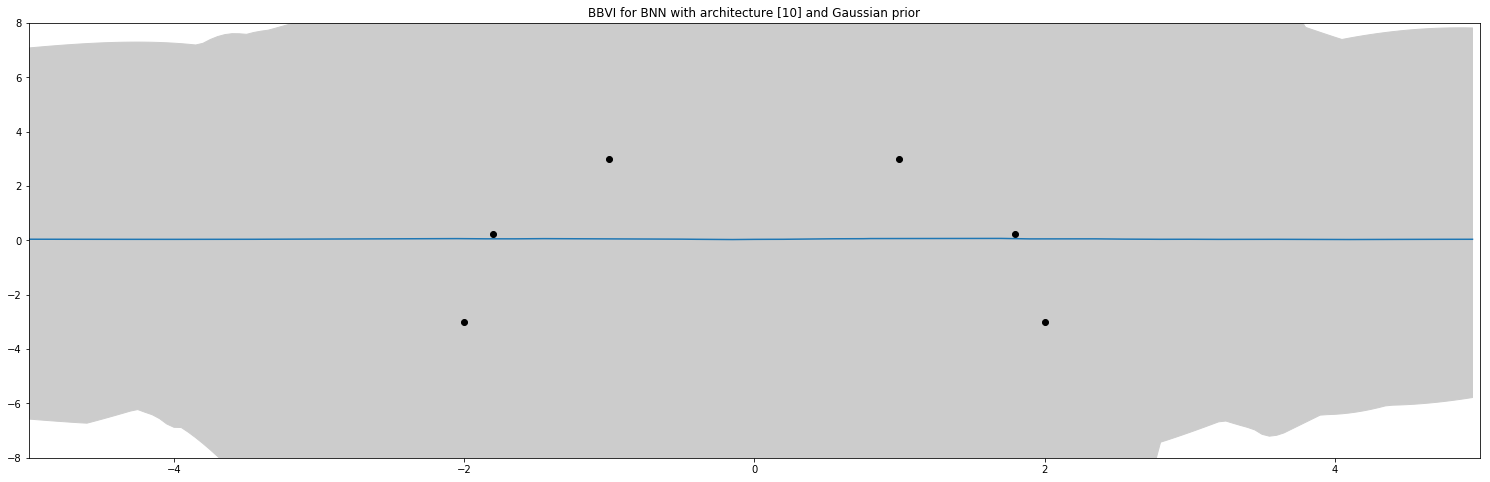

In [13]:
preds = []
for _ in range(5000):
    pred = model(x_range, Normal(model.lambdas[:31], torch.exp(model.lambdas[31:])).sample())
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
bounds = (np.sort(preds, axis=1)[:, 1], np.sort(preds, axis=1)[:,-1])
mean = np.mean(preds, axis=1)

plt.gca().set_title('BBVI for BNN with architecture [10] and Gaussian prior')
plt.gca().fill_between(x_range.reshape(-1), bounds[1], bounds[0], color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')

plt.plot(to_numpy(x_range), mean)
# plt.scatter(X,Y)
plt.axis([-5,5,-8,8])
plt.show()

In [16]:
# Calculate means and standard deviations of gradient updates
gs = []
for m in range(100):
    model = SingleLayerNet(10)
    optimizer = torch.optim.SGD([model.lambdas], lr=1e-4)
    model, _ = BBVI(X, Y, model, optimizer, num_samples=100, epochs=int(1))
    gs.append(model.lambdas.grad)
gs = torch.stack(gs, dim=1)
for w in [1,5,7,15,21,30]:
    print('{:+5.4f} | {:+5.4f}'.format(gs[w].mean().item(), gs[w].std().item()))

+9.1387 | +269.9940
-13.6715 | +289.2142
-16.9426 | +292.8768
+10.4562 | +272.6976
-87.2402 | +243.0557
-46.2390 | +324.8989


In [89]:
# plt.plot(to_numpy(x_range), to_numpy(model(x_range)))
# plt.scatter(X,Y)

In [ ]:
# # Plot
# fnames = [ ('1_10_1.pth', '[1,10,1]'), ('1_50_1.pth', '[1,50,1]'), ('1_10_10_1.pth', '[1,10,10,1]'), ('1_50_50_1.pth', '[1,50,50,1]') ]

# for i, (fname, name) in enumerate(fnames):
#   samples = torch.load(fname).squeeze().transpose(0,1).detach().cpu().numpy()
#   upper_95 = np.sort(samples, axis=1)[:, 50] 
#   lower_95 = np.sort(samples, axis=1)[:,-50]
  
#   # Plot
#   plt.subplot(2,2,i+1)
#   plt.gca().set_title('BNN with Gaussian prior and network architecture ' + name)
#   plt.gca().fill_between(x_range.reshape(-1), upper_95, lower_95, color="#cccccc")
#   plt.scatter(X, Y, color='black', marker='o')

# plt.show()